# Reinforcement Learning with Human Feedback (RLHF)


- RLHF is an interactive approach to tuning a LLM with human evalution of the quality of responses provided by the LLM. This feedback is used with RL to tune the LLM. Usually the RL implementation uses proximal policy optimization (PPO), an effective algorithm for RL. A common objective of RLHF is to tune the LLM to prevent it from generating toxic language or to train it to refuse to answer specific types of questions, such as those dealing with racism or bias, or not offer medical and financial advice. Thus, RLHF is effective in adding guardrails to LLMs. More generally, RLHF enables the incorporation of human preferences in to LLMs.

- Therefore, RLHF is useful in addressing the "alignment problem" in AI models.

- You have seen this when using the thumbs-up/thumbs-down feedback buttons in chatbots. This data is used for RLHF tuning.

- But you may not have learnt about reinforcement learning (RL), and here is a good reference that is easy to follow with no background: https://cameronrwolfe.substack.com/p/basics-of-reinforcement-learning

- A good reference: https://magazine.sebastianraschka.com/p/llm-training-rlhf-and-its-alternatives

- General class notes on RL: https://srdas.github.io/RLBook2/


In [1]:
%%capture
#INCLUDING SCIENTIFIC AND NUMERICAL COMPUTING LIBRARIES
#Run this code to make sure that you have all the libraries at one go.
%pylab inline
import os
# !pip install ipypublish
# from ipypublish import nb_setup
import pandas as pd
# %load_ext rpy2.ipython
from IPython.display import Image

In [2]:
# Basic lines of code needed to import a data file with permissions from Google Drive
from google.colab import drive
# drive.mount("/content/drive", force_remount=True)
drive.mount('/content/drive')
os.chdir("drive/My Drive/Books_Writings/NLPBook/")

Mounted at /content/drive


## So what is Reinforcement Learning?

A brief introduction with examples: https://srdas.github.io/NLPBook/ReinforcementLearning.html, from another section of the notes.

## LLM Curation

Therefore, curating an LLM requires various types of training: (1) Pretraining the language transformer (this is a large-scale effort often requiring the repeated use of a trillion tokens or more). This is unsupervised or self-supervised. (2) Fine-tuning the LLM on data with labels, i.e., supervised tuning. (3) RLHF for alignment.

1. **Pretraining** is undertaken with a simple next word prediction task. This often known as self-supervised training because the data is its own label. This uses vast amounts of data, often over 1T tokens.

2. **Supervised fine-tuning** uses instruction + input + response pairs. This too is a type of next token prediction, where the instruction and input are taken as given and next token prediction training is applied on the supplied response. The amount of data used here is much less, usually a few thousand examples. This gently tunes the pretrained LLM and is also convenient because preparing "instruction tuning" datasets is costly. There are two types of fine-tuning:

  - Domain-adapted fine-tuning (see our GPT2 example)
  - Instruction fine-tuning (instruction + input + response sets)

3. **RLHF** is the alignment step. This too requires a few thousand examples. See the [InstructGPT](https://arxiv.org/abs/2203.02155) paper titled "Training language models to follow instructions with human feedback".


## Quick Overview of RLHF

http://arxiv.org/abs/2203.02155. It is worth taking an intuitive look at the internals of the RLHF procedure (in the OpenAI paper).

- Step 1 is straight up SFT using sets of queries and responses prepared by humans.

- In Step 2 the LLM generates four responses, which are ranked by a human (ordinal rewards), and the dataset is used to train a neural net (the reward model) to predict/rank best responses. For an example of this type of dataset, see: https://huggingface.co/datasets/cais/mmlu/viewer/high_school_macroeconomics

- Step 3 exploits the fact that if you have a reward model, then you can replace the human in the loop and then just use a set of queries to get responses that can be evaluated by the reward model. This is just plain RL and OpenAI used the PPO (proximal policy optimization, a particular type of actor-critic RL model) algorithm to tune/train the LLM, which is now treated as if its neural net is a policy function that generates chunks of text. The main graphic from the OpenAI paper is shown here:

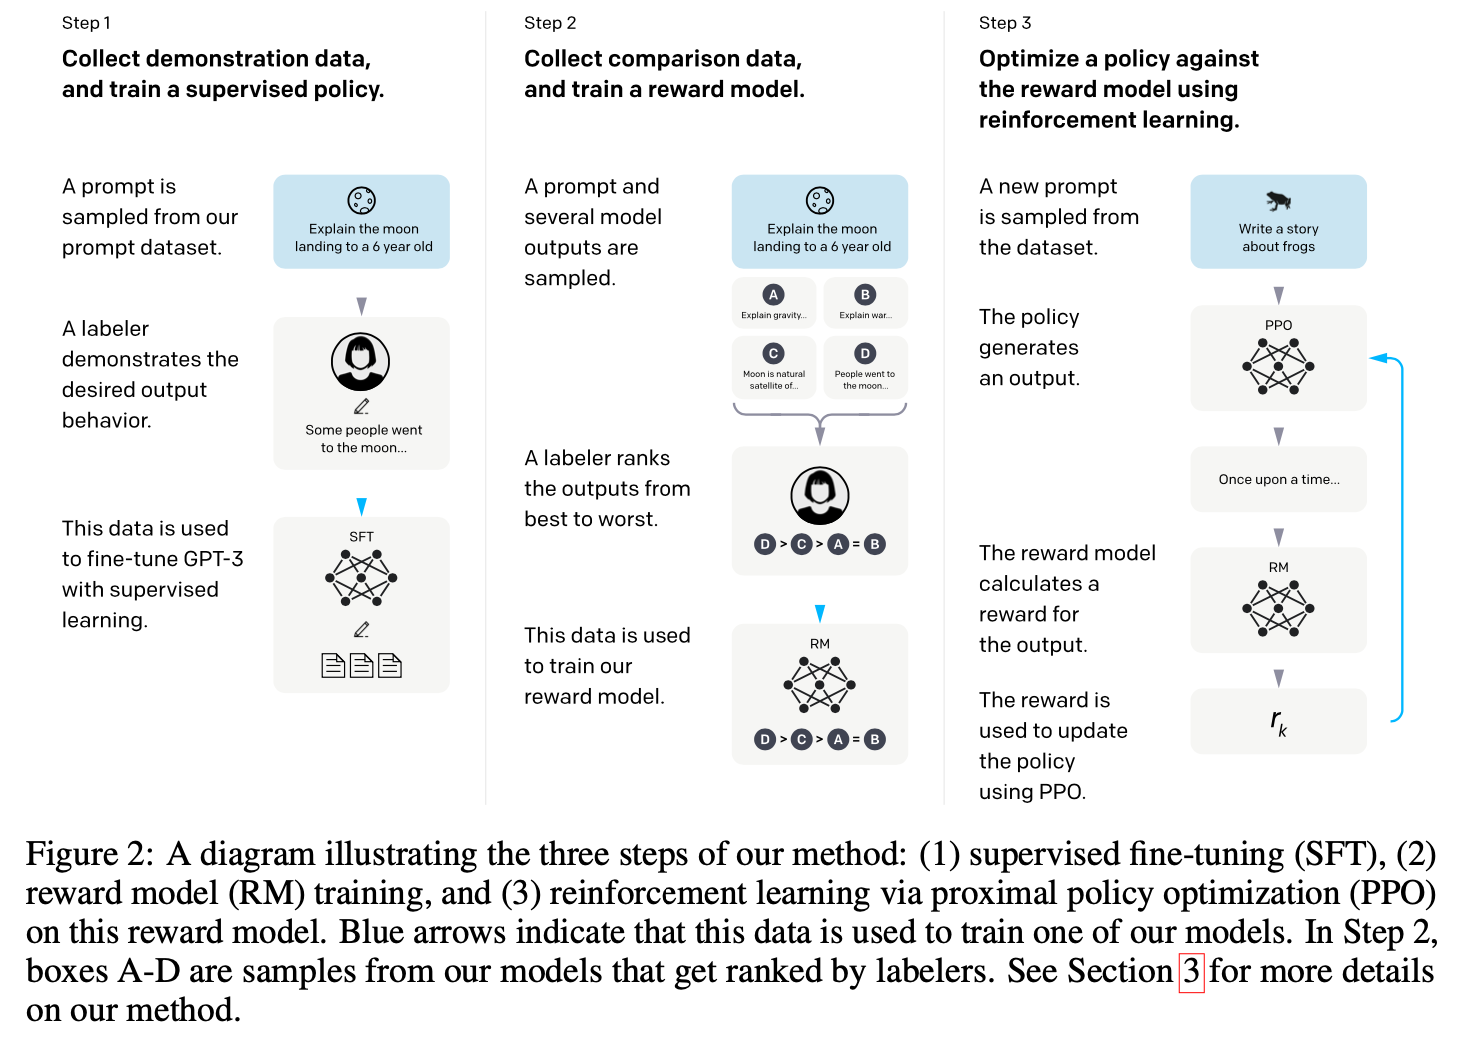

In [3]:
Image('NLP_images/rlhf.png', width=800)

## RLHF Steps in InstructGPT

RLHF as outlined in the InstructGPT paper involves the following steps:

1. Fine-tuning from human responses. Here, we generate prompts and then ask humans to write a response. These responses are then used for supervised training using the next token prediction task.

2. Ask the LLM from step 1 above to generate a few responses to the same prompt (usually four responses). A human then ranks the responses based on personal preference. This creates the required data for a reward model.

3. Optimize a reward model using the data from step 2 above. A reward model typically outputs a continuous reward value and hence is analogous to a regression model. The reward model is the neural net from Step 2 with a single output node. The reward is optimized using reinforcement learning (RL), specifically proximal policy optimization (PPO).

## PPO articles

The seminal papers that detail PPO for RL are:

1. "Asynchronous Methods for Deep Reinforcement Learning" (2016) by Mnih, Badia, Mirza, Graves, Lillicrap, Harley, Silver, and Kavukcuoglu introduces policy gradient methods as an alternative to Q-learning in deep learning-based RL. http://arxiv.org/abs/1602.01783

2. "Proximal Policy Optimization Algorithms" (2017) by Schulman, Wolski, Dhariwal, Radford, and Klimov presents a modified proximal policy-based reinforcement learning procedure that is more data-efficient and scalable than the vanilla policy optimization algorithm above. This is widely acknowledged to be the main paper that outlines the popular version of PPO in use. http://arxiv.org/abs/1707.06347

3. "Fine-Tuning Language Models from Human Preferences" (2020) by Ziegler, Stiennon, Wu, Brown, Radford, Amodei, Christiano, Irving illustrates the concept of PPO and reward learning to pretrained language models including KL regularization to prevent the policy from diverging too far from natural language. http://arxiv.org/abs/1909.08593

4. "Learning to Summarize from Human Feedback" (2022) by Stiennon, Ouyang, Wu, Ziegler, Lowe, Voss, Radford, Amodei, Christiano introduces the popular RLHF three-step procedure that was later also used in the InstructGPT paper. http://arxiv.org/abs/2009.01325

## RLHF Steps in Llama2

The steps here are somewhat different from the InstructGPT paper. This procedure was used to develop the Llama2-chat class of models. See the paper: http://arxiv.org/abs/2307.09288

There are some differences implemented in Llama2:

1. The reward model has two types of reward, a safety reward model to manage toxicity, etc., and a helpful reward model that is similar to the one in InstructGPT.

2. In addition to reward maximization using PPO, there is also a rejection sampling step. *What is rejection sampling?* = only use examples that have high rewards and reject examples with low rewards.

3. Human labelers see only two responses for ranking, not four. So this is a binary ranking task and the human is also asked to provide a margin label, which is a continuous value expressing their quantification of the difference in quality of the two responses.

4. Cross entropy based loss is used to train the reward model using PPO (in both InstructGPT and Llama2-chat). Because of the margin label from 3 above, the loss function is modified in Llama2-chat to be

$$
L = -\log[\sigma(r_{\theta})(x,y_c) - r_{\theta})(x,y_r) - m(r))]
$$

where $\sigma(\cdot) \in (0,1)$ is a sigmoid function; reward function $r_{\theta}(x,y)$ with prompt $x$ and response $y$ and $\theta$ are the model weights. Responses may be preferred by human annotators, i.e., $y_c$, or rejected, $y_r$. Finally, $m(r)$ is the reward margin.



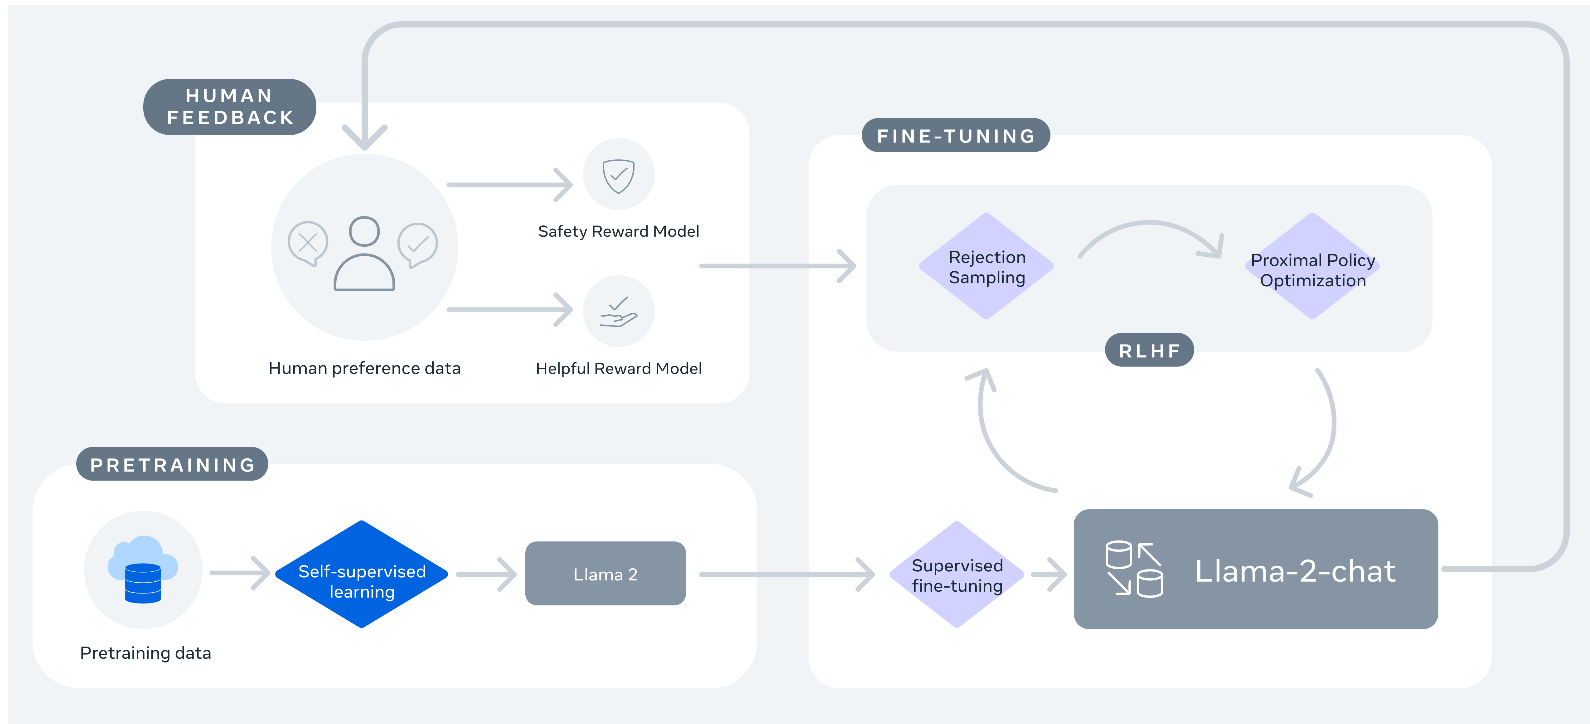

In [4]:
Image('NLP_images/rlhf_llama2.png', width=1000)

A combination of PPO and rejection sampling gives incrementally better results. See the figure from the LLama2 paper ("Llama 2: Open Foundation and Fine- Tuned Chat Models", https://arxiv.org/abs/2307.09288)




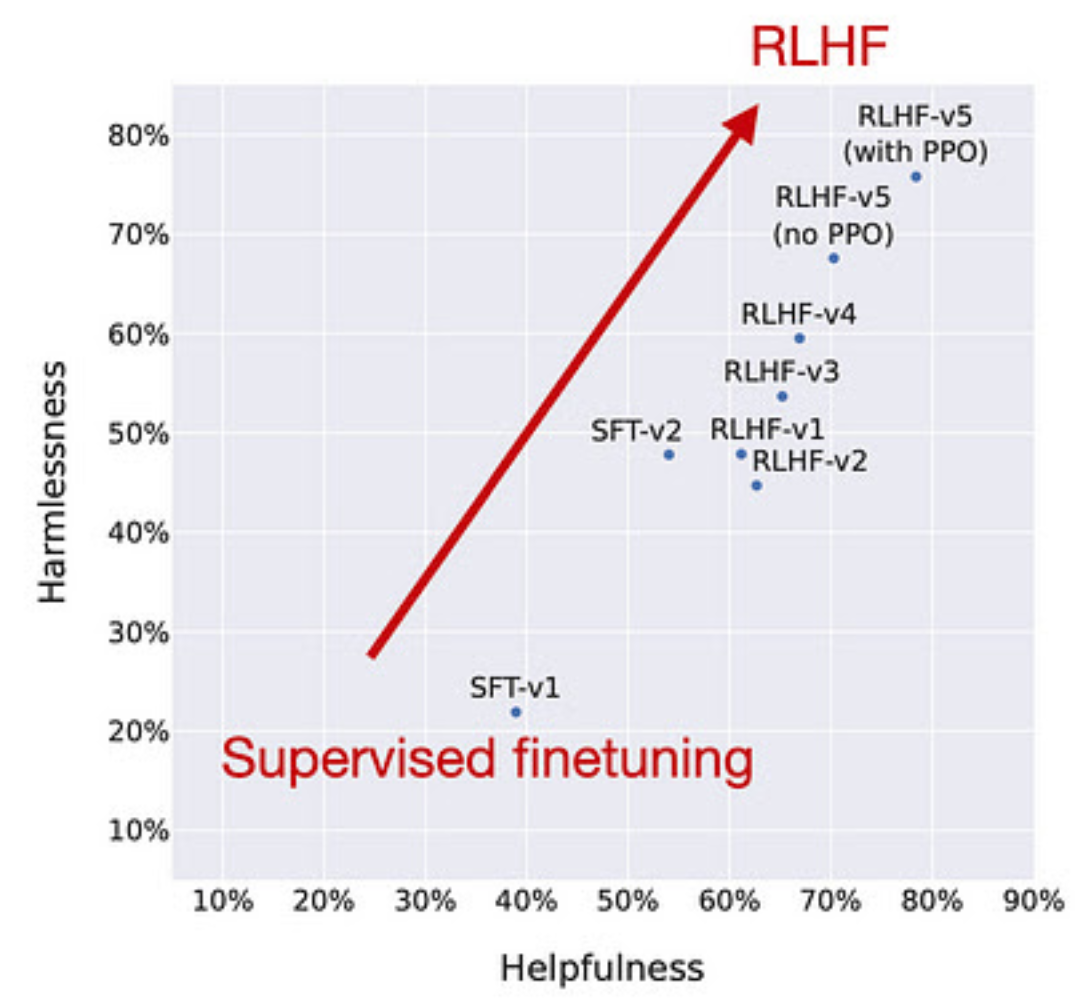

In [5]:
Image('NLP_images/Llama2_rlhf.png', width=500)

## HHH

See also the 3Hs paradigm from Anthropic: https://docs.anthropic.com/en/docs/resources/glossary#hhh

The three H’s represent Anthropic’s goals in ensuring that Claude is beneficial to society.

1. A **helpful** AI will attempt to perform the task or answer the question posed.
2. An **honest** AI will give accurate information, and not hallucinate or confabulate.
3. A **harmless** AI will not be offensive or discriminatory, and when asked to aid in a dangerous act, the AI should politely refuse.


## Alternate approaches

- The paper "Constitutional AI: Harmlessness from AI Feedback" (https://arxiv.org/abs/2212.08073) from Cohere uses adversarial or "red-teaming" queries and a reward model that disincentivizes harmful responses. It uses preset rules to critique the responses, known as the Constitution.

- "The Wisdom of Hindsight Makes Language Models Better Instruction Followers" (https://arxiv.org/abs/2302.05206). A relabeling-based supervised approach for finetuning that outperforms RLHF on 12 BigBench tasks. Instruct the LLM to respond to prompts. Humans assess the prompts and responses and when the responses are not satisfactory the instructions (prompts) are revised. This approach uses hindsight to change the prompts to better match the responses.

- "Reinforced Self-Training (ReST) for Language Modeling" (https://arxiv.org/abs/2308.08998). Create a better and better dataset by repeated sampling and keeping better prompt, query, response examples.

- "RLAIF: Scaling Reinforcement Learning from Human Feedback with AI Feedback" (https://arxiv.org/abs/2309.00267). Instead of humans, use a strong LLM to rank the responses.

- An excellent graphical (flashchards) exposition of various adaptations of RLHF: https://www.turingpost.com/p/rl-f
